# K-Means

In [41]:
import numpy as np
from collections import defaultdict

def preprocess_dataframe(df):
    """
    Converts DataFrame to NumPy array, removes label column if present.
    """
    X = df.select_dtypes(include=[np.number])  # remove non-numeric columns
    return X.values

def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
    return new_centroids

def has_converged(old_centroids, new_centroids):
    return np.allclose(old_centroids, new_centroids)

def kmeans(X, k, max_iters=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if has_converged(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels, centroids

def print_cluster_assignments(labels):
    cluster_dict = defaultdict(list)
    for idx, cluster_id in enumerate(labels):
        cluster_dict[cluster_id].append(idx)
    for cluster_id in sorted(cluster_dict.keys()):
        print(f"Cluster {cluster_id}: {cluster_dict[cluster_id]}")
        print()

def compute_wcss(X, labels, centroids):
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        wcss += np.sum((cluster_points - centroids[i])**2)
    return wcss

from sklearn.metrics import silhouette_score

def compute_silhouette(X, labels):
    """
    Computes silhouette coefficient for clustering result.
    Returns None if silhouette score cannot be computed.
    """
    # Silhouette score requires at least 2 clusters and less than n samples clusters
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 1 or len(unique_labels) >= len(X):
        return None
    return silhouette_score(X, labels)

def save_metrics_to_file_k(name,k,wcss, silhouette, filename="metrics.txt"):
    with open(filename, "a") as f:
        f.write(f"{name}             k_means            {wcss:.4f}         {silhouette:.4f}       {k}\n")
    

def run_kmeans(df, k,name, collect_metrics=False):
    X = preprocess_dataframe(df)
    labels, centroids = kmeans(X, k)
    
    wcss = compute_wcss(X, labels, centroids)
    silhouette = compute_silhouette(X, labels)
    
    print("=== Final Centroids ===")
    print(centroids)

    print("\n=== Cluster Assignments ===")
    print_cluster_assignments(labels)

    print(f"\nWithin-Cluster Sum of Squares (WCSS): {wcss:.4f}")
    w=wcss
    sil=-1
    if silhouette is not None:
        print(f"Silhouette Coefficient: {silhouette:.4f}")
        sil=silhouette
    else:
        print("Silhouette Coefficient: Not defined for given clustering.")

    print("=" * 50 + "\n")

    save_metrics_to_file_k(name,k,w,sil)
    
    if collect_metrics:
        return wcss, sil

    

# DBSCAN

In [42]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import silhouette_score

UNVISITED = 0
VISITED = 1
NOISE = -1

def preprocess_dataframe(df):
    """
    Converts DataFrame to NumPy array and keeps only numeric columns.
    """
    X = df.select_dtypes(include=[np.number])
    return X.values

def region_query(X, point_idx, eps):
    """
    Finds indices of all points in X within eps distance of point_idx.
    """
    distances = np.linalg.norm(X - X[point_idx], axis=1)
    return np.where(distances <= eps)[0]

def expand_cluster(X, labels, point_idx, cluster_id, eps, min_pts, visited):
    neighbors = region_query(X, point_idx, eps)

    if len(neighbors) < min_pts:
        labels[point_idx] = NOISE
        return False
    else:
        labels[point_idx] = cluster_id
        visited[point_idx] = VISITED

        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if visited[neighbor_idx] == UNVISITED:
                visited[neighbor_idx] = VISITED
                neighbor_neighbors = region_query(X, neighbor_idx, eps)
                if len(neighbor_neighbors) >= min_pts:
                    neighbors = np.concatenate((neighbors, neighbor_neighbors))

            if labels[neighbor_idx] == NOISE or labels[neighbor_idx] == UNVISITED:
                labels[neighbor_idx] = cluster_id

            i += 1

        return True

def dbscan(X, eps, min_pts):
    labels = np.full(X.shape[0], UNVISITED)
    visited = np.full(X.shape[0], UNVISITED)
    cluster_id = 0

    for point_idx in range(X.shape[0]):
        if visited[point_idx] == UNVISITED:
            if expand_cluster(X, labels, point_idx, cluster_id, eps, min_pts, visited):
                cluster_id += 1

    return labels

def compute_wcss_k(X, labels):
    """
    WCSS (in DBSCAN) computed per cluster using mean of assigned points.
    Ignores noise points (label = -1).
    """
    wcss = 0
    unique_labels = [label for label in set(labels) if label != NOISE]
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
            wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

def compute_silhouette(X, labels):
    if len(set(labels)) <= 1 or len(set(labels)) >= len(X):
        return None
    try:
        return silhouette_score(X, labels)
    except:
        return None

def print_cluster_assignments(labels):
    cluster_dict = defaultdict(list)
    for idx, label in enumerate(labels):
        cluster_dict[label].append(idx)
    for cluster_id in sorted(cluster_dict.keys()):
        label_name = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
        print(f"{label_name}: {cluster_dict[cluster_id]}\n")

def save_metrics_to_file(name,wcss, eps,minpts,silhouette, filename="metrics.txt"):
    with open(filename, "a") as f:
        f.write(f"{name}             db_scan            {wcss:.4f}        {silhouette:.4f}              {eps:.2f}           {minpts}\n")

def run_dbscan(name,df, eps, min_pts, collect_metrics=False):
    X = preprocess_dataframe(df)
    labels = dbscan(X, eps, min_pts)

    wcss = compute_wcss_k(X, labels)
    silhouette = compute_silhouette(X, labels)
    sil=0
    if silhouette:
        sil=silhouette
    else:
        sil=-1

    print("=== Cluster Assignments ===")
    print_cluster_assignments(labels)

    print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}")
    if silhouette is not None:
        print(f"Silhouette Coefficient: {silhouette:.4f}")
    else:
        print("Silhouette Coefficient: Not defined for this clustering.")
    print("=" * 50 + "\n")
    save_metrics_to_file(name,wcss,eps,min_pts,sil)
    if collect_metrics:
        return wcss, sil



# Comparison

In [43]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

ucirepo_ids = {
    "credit":27, "kidney":336, "energy":242, "abalone":1,
    "statlog":144, "student":320, "wine":109, "iris":53,
    "breast_cancer":17, "birch1":721, "solar_flare":89, "heart_disease":45
}

def fetch_dataset(name):
    dataset = fetch_ucirepo(id=ucirepo_ids[name])
    return dataset.data.features

def encode_categorical(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

def estimate_density(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    avg_k_dist = np.mean(distances[:, -1])
    return avg_k_dist

def auto_dbscan_params(X):
    dim = X.shape[1]
    min_pts = max(4, dim + 1)
    avg_density = estimate_density(X, k=min_pts)
    eps = avg_density * 1.5
    return eps, min_pts

def auto_k(X):
    return int(np.sqrt(len(X)) // 2)

def main():
    results = []

    for name in list(ucirepo_ids.keys()):
        try:
            print(f"\n==== {name.upper()} ====\n")
            df = fetch_dataset(name)
            df = encode_categorical(df)
            df = df.fillna(df.mean(numeric_only=True))
            X = df.select_dtypes(include=[np.number])
            if X.shape[1] == 0:
                print(f"⚠️ Skipping '{name}' — no numeric features.")
                continue

            X_np = X.values
            k = auto_k(X_np)
            eps, min_pts = auto_dbscan_params(X_np)

            print("📌 K-Means")
            k_wcss, k_sil = run_kmeans(df, k, name, collect_metrics=True)

            print("📌 DBSCAN")
            d_wcss, d_sil = run_dbscan(name, df, eps, min_pts, collect_metrics=True)

            results.append({
                "dataset": name,
                "kmeans_log_wcss": np.log1p(k_wcss),  # log1p handles 0 safely
                "kmeans_sil": k_sil,
                "dbscan_log_wcss": np.log1p(d_wcss),
                "dbscan_sil": d_sil
            })


        except Exception as e:
            print(f"❌ Error in dataset '{name}': {e}")
            continue

    # Convert to DataFrame for plotting
    df_results = pd.DataFrame(results)
    df_results.to_csv("clustering_results.csv", index=False)
    print("\n✅ Saved clustering_results.csv")

    plot_comparisons(df_results)

def plot_comparisons(df_results):
    datasets = df_results['dataset']

    x = np.arange(len(datasets))
    width = 0.35

    # Plot WCSS comparison
    plt.bar(x - width/2, df_results['kmeans_log_wcss'], width, label='K-Means')
    plt.bar(x + width/2, df_results['dbscan_log_wcss'], width, label='DBSCAN')
    plt.ylabel("log(WCSS + 1)")
    plt.title("Log(WCSS) Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig("log_wcss_comparison.png")
    plt.show()

    # Plot Silhouette comparison
    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, df_results['kmeans_sil'], width, label='K-Means')
    plt.bar(x + width/2, df_results['dbscan_sil'], width, label='DBSCAN')
    plt.xticks(x, datasets, rotation=45)
    plt.ylabel("Silhouette Coefficient")
    plt.title("Silhouette Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig("silhouette_comparison.png")
    plt.show()



==== CREDIT ====

📌 K-Means
=== Final Centroids ===
[[5.32287500e+03 1.63083949e+02 0.00000000e+00 5.41666667e-01
  4.95833333e+00 6.25000000e-01 7.50000000e-01 2.93916667e+00
  4.41666667e+00 6.20833333e+00 2.50000000e-01 1.12500000e+00
  6.13875000e+00 3.26670071e+01 7.08333333e-01]
 [6.70333333e+04 4.48333333e+02 3.33333333e-01 6.66666667e-01
  2.33333333e+00 6.66666667e-01 6.66666667e-01 2.68000000e+00
  4.33333333e+00 3.66666667e+00 3.33333333e-01 6.66666667e-01
  1.05133333e+01 3.30300000e+01 6.66666667e-01]
 [5.13583333e+01 2.08342898e+02 1.83333333e-01 4.41666667e-01
  1.73333333e+00 3.33333333e-01 3.33333333e-01 1.23945833e+00
  5.24166667e+00 5.79166667e+00 8.16666667e-01 1.43333333e+00
  3.07775000e+00 3.07114014e+01 7.50000000e-01]
 [1.22938000e+04 1.48100000e+02 0.00000000e+00 3.00000000e-01
  5.10000000e+00 7.00000000e-01 1.00000000e+00 4.60350000e+00
  5.50000000e+00 5.20000000e+00 4.00000000e-01 1.20000000e+00
  6.22850000e+00 3.99160000e+01 7.00000000e-01]
 [5.0000000

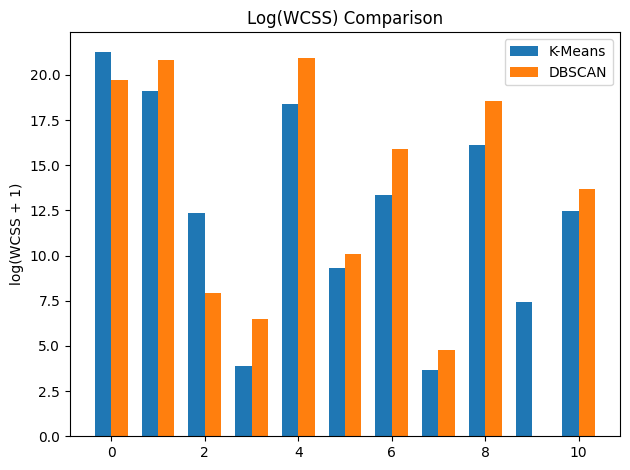

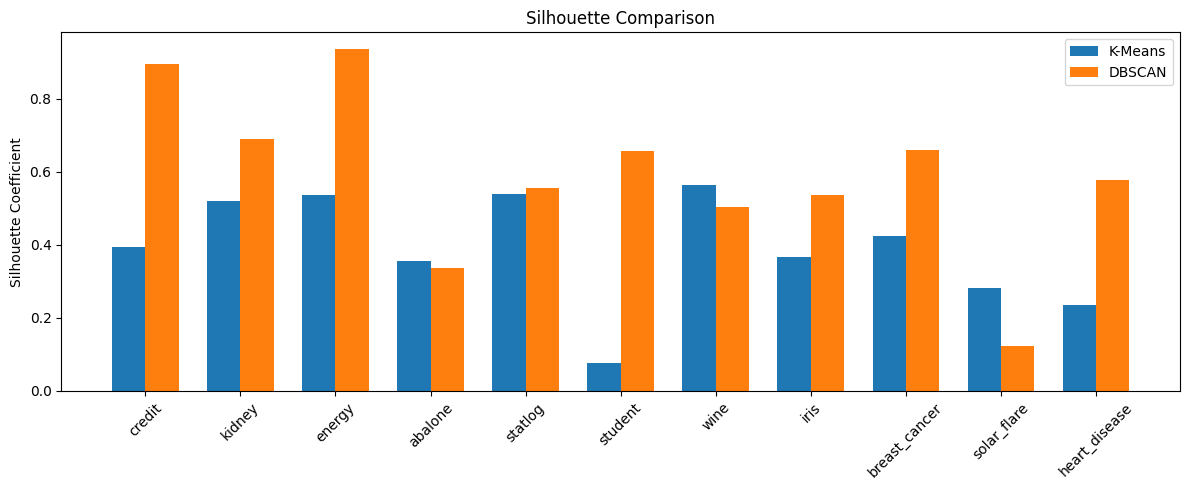

In [44]:
main()